https://eli5.readthedocs.io/en/latest/_modules/eli5/sklearn/explain_weights.html
https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#explaining-predictions

Prøv at tage, f. eks., Vinterraps mod alle andre (dvs. binær klassifikation), og se hvilke datoer der gør at vinterraps er let at få øje på.

Prøv også at kigge på https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html.

In [33]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Barley',
    'Vinterbyg': 'Barley',
    'Grønkorn af vårbyg': 'Barley',
    'Vårbyg, helsæd': 'Barley',
    'Vinterhvede': 'Wheat',
    'Vårhvede': 'Wheat',
    'Vinterhybridrug': 'Rye',
    'Vårhavre': 'Oat',
    'Silomajs': 'Maize',
    'Majs til modenhed': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Sukkerroer til fabrik': 'Sugarbeet',
    'Permanent græs, normalt udbytte': 'Grass',
    'Skovdrift, alm.': 'Forest',
    'Juletræer og pyntegrønt på landbrugsjord': 'Forest'
}

# Set seed for random generators
RANDOM_SEED = 42

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 32.8 ms


In [4]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 219 ms


In [5]:
ds.close()

time: 34.8 ms


In [6]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.6 s


In [48]:
df_sklearn = get_sklearn_df(polygons_year=2019, 
                            satellite_dates=slice('2018-01-01', '2019-12-31'), 
                            fields='all', 
                            satellite='S1B', 
                            polarization='all',
                            crop_type='all',
                            netcdf_path=netcdf_path)
    
df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1

for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
#print(f"Crop types: {class_names}")

# Get values as numpy array
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Instantiate and evaluate classifier
from sklearn.linear_model import LogisticRegression          
clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                    feature_scale=True, plot_confusion_matrix=False,
                                                                    print_classification_report=True)

Training time: 37.7488 s
Prediction time: 0.0073 s

Report:

Train accuracy: 0.8639
Test accuracy: 0.8627

               precision    recall  f1-score   support

      Potato       0.97      0.96      0.97      2324
      Barley       0.77      0.84      0.81      4332
       Wheat       0.85      0.74      0.79      1575
         Rye       0.96      0.96      0.96      1423
         Oat       0.81      0.68      0.74      1390
       Maize       0.92      0.93      0.92      1633
    Rapeseed       0.99      0.99      0.99      1108
   Sugarbeet       1.00      0.83      0.91        24
       Grass       0.71      0.74      0.72      1128
      Forest       0.90      0.90      0.90      1573

    accuracy                           0.86     16510
   macro avg       0.89      0.86      0.87     16510
weighted avg       0.86      0.86      0.86     16510

time: 58.5 s


In [49]:
print("IMPORTANT!!!! REMEMBER TO CORRECT THE 'accuracy' ROW MANUALLY - IT IS RUINED WHEN THE DICT IS CONVERTED TO DATAFRAME")
df_results = pd.DataFrame(results_report).transpose()
print(df_results.round(2).astype({'support': 'int32'}).to_latex(index=True))  

IMPORTANT!!!! REMEMBER TO CORRECT THE 'accuracy' ROW MANUALLY - IT IS RUINED WHEN THE DICT IS CONVERTED TO DATAFRAME
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Potato       &       0.97 &    0.96 &      0.97 &     2324 \\
Barley       &       0.77 &    0.84 &      0.81 &     4332 \\
Wheat        &       0.85 &    0.74 &      0.79 &     1575 \\
Rye          &       0.96 &    0.96 &      0.96 &     1423 \\
Oat          &       0.81 &    0.68 &      0.74 &     1390 \\
Maize        &       0.92 &    0.93 &      0.92 &     1633 \\
Rapeseed     &       0.99 &    0.99 &      0.99 &     1108 \\
Sugarbeet    &       1.00 &    0.83 &      0.91 &       24 \\
Grass        &       0.71 &    0.74 &      0.72 &     1128 \\
Forest       &       0.90 &    0.90 &      0.90 &     1573 \\
accuracy     &       0.86 &    0.86 &      0.86 &        0 \\
macro avg    &       0.89 &    0.86 &      0.87 &    16510 \\
weighted avg &       0.86 &    0.86 &      0.8

In [50]:
try:
    from eli5 import show_weights
except:
    !conda install -y eli5

time: 19.5 ms


In [51]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = df_sklearn.columns[3:]
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.explain_weights(clf, feature_names=list(feature_names), target_names=class_names)
# Look at https://eli5.readthedocs.io/en/latest/autodocs/formatters.html#eli5.formatters.html.format_as_html

# IMPORTANT: LOOK HERE TO FIND IMPORTANCE FOR INDIVIDUAL CLASSES:
#            https://stackoverflow.com/questions/59245580/eli5-explain-weights-does-not-returns-feature-importance-for-each-class-with-skl

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=1000,\n                   multi_class='auto', n_jobs=32, penalty='l2',\n                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Potato', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='2019-06-09_VV', weight=0.9683388515045087, std=None, value=None), FeatureWeight(feature='2019-07-27_VV', weight=0.830204394057615, std=None, value=None), FeatureWeight(feature='2019-03-05_VV', weight=0.8075780733846168, std=None, value=None), FeatureWeight(feature='2019-07-15_VV', weight=0.7704064910223821, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.7199868517535503, std=None, value=None), FeatureWeight(feature='2019-06-21_VV', weight=0.66192731859537, std=None, value=None), FeatureWeight(feature='2019-09-13_VV', weight=0.6451259805852018, std=None, value=None), FeatureWeight(feature='2019-02-09_VV', weight=0.6202802408777245, std=None, value=None), FeatureWeight(feature='2019-07-15_VV-VH', weight=0.6180721102966016, std=None, value=None), FeatureWeight(feature='2018-09-18_VV', weight=0.5523506036919429, std=None, value=None), FeatureWeight(feature='2019-09-01_VV', weight=0.5183274685849636, std=None, value=None), FeatureWeight(feature='2019-07-03_VH', weight=0.5068115600054138, std=None, value=None), FeatureWeight(feature='2018-12-11_VV', weight=0.47578066215723247, std=None, value=None)], neg=[FeatureWeight(feature='2019-04-22_VH', weight=-0.9959347953115777, std=None, value=None), FeatureWeight(feature='2019-04-10_VH', weight=-0.78764869688552, std=None, value=None), FeatureWeight(feature='2019-03-05_VV-VH', weight=-0.6689496738352111, std=None, value=None), FeatureWeight(feature='2019-01-04_VH', weight=-0.6613916263831365, std=None, value=None), FeatureWeight(feature='2019-08-08_VH', weight=-0.5672275811719609, std=None, value=None), FeatureWeight(feature='2018-09-30_VH', weight=-0.5062207441372842, std=None, value=None), FeatureWeight(feature='2018-11-29_VH', weight=-0.47149157796193436, std=None, value=None)], pos_remaining=49, neg_remaining=49), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='Barley', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=4.759261174012471, std=None, value=None), FeatureWeight(feature='2019-06-09_VH', weight=2.686897707818403, std=None, value=None), FeatureWeight(feature='2019-06-09_VV-VH', weight=2.661919244732684, std=None, value=None), FeatureWeight(feature='2019-05-04_VV-VH', weight=1.8453879210372637, std=None, value=None), FeatureWeight(feature='2019-05-04_VH', weight=1.3828211515645614, std=None, value=None), FeatureWeight(feature='2019-06-21_VH', weight=1.298243591501503, std=None, value=None), FeatureWeight(feature='2019-08-20_VV-VH', weight=0.855296382921892, std=None, value=None), FeatureWeight(feature='2019-04-22_VH', weight=0.7529493425437148, std=None, value=None), FeatureWeight(feature='2019-08-20_VH', weight=0.7481389075581666, std=None, value=None), FeatureWeight(feature='2019-10-07_VV-VH', weight=0.7128173253591016, std=None, value=None), FeatureWeight(feature='2019-04-22_VV-VH', weight=0.6857220951032039, std=None, value=None), FeatureWeight(feature='2018-10-24_VV-VH', weight=0.

time: 2.2 s


In [52]:
df_explanation = eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names=list(feature_names))
df_explanation = df_explanation.sort_values(by=['feature'])
df_explanation['polarization'] = ''
features = df_explanation['feature'].unique()
for feature in features:
    if feature[-5:] == 'VV-VH':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
        df_explanation = df_explanation.replace(feature, feature[:-6])
    elif feature[-2:] == 'VV':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
        df_explanation = df_explanation.replace(feature, feature[:-3])
    else:
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
        df_explanation = df_explanation.replace(feature, feature[:-3])
        
# OLD CODE:
#df_explanation_vh = df_explanation.iloc[::3]
#df_explanation_vh['polarization'] = 'VH'
#df_explanation_vh['feature'] = df_explanation_vh['feature'].map(lambda x: str(x)[:-3])
#df_explanation_vv = df_explanation.iloc[1::3]
#df_explanation_vv['polarization'] = 'VV'
#df_explanation_vv['feature'] = df_explanation_vv['feature'].map(lambda x: str(x)[:-3])
#df_explanation_vvvh = df_explanation.iloc[2::3]
#df_explanation_vvvh['polarization'] = 'VV-VH'
#df_explanation_vvvh['feature'] = df_explanation_vvvh['feature'].map(lambda x: str(x)[:-6])
#df_explanation = pd.concat([df_explanation_vh, df_explanation_vv, df_explanation_vvvh])

time: 419 ms


In [53]:
df_explanation.head(3)

,feature,weight,std,polarization
19,2018-07-08,0.000170,0.000408,VH
101,2018-07-08,-0.002907,0.000367,VV
69,2018-07-08,-0.000654,0.000124,VV-VH


time: 35.4 ms


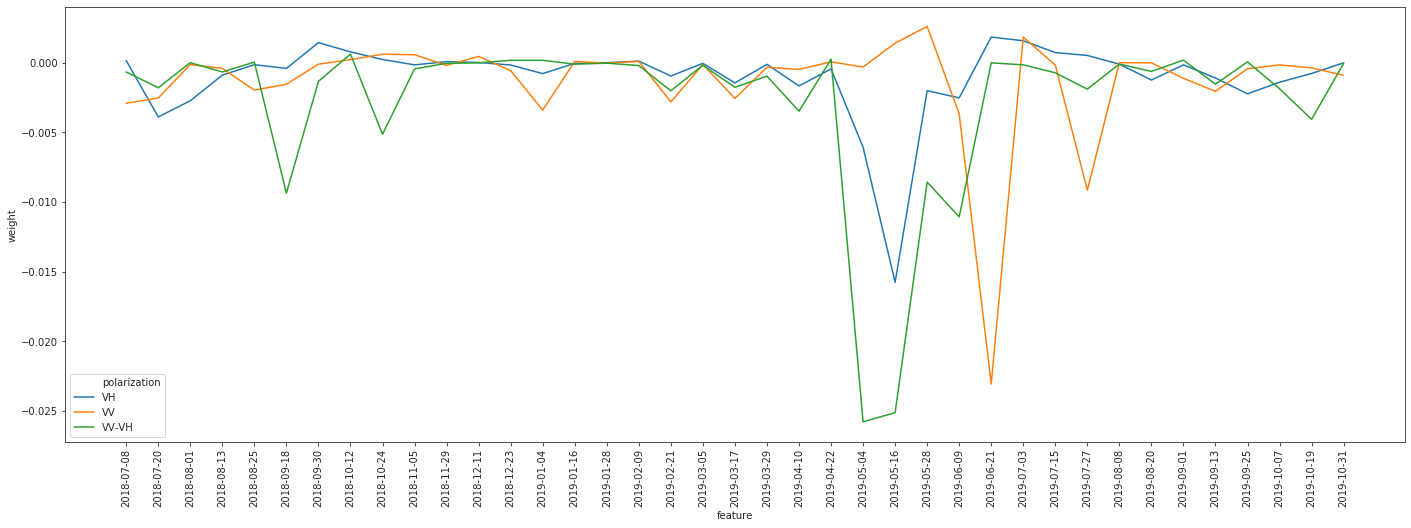

time: 447 ms


In [54]:
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=df_explanation, ci='sd')

In [55]:
#df_explanation = eli5.formatters.as_dataframe.explain_prediction_df(perm, feature_names=list(feature_names))

time: 40.1 ms


In [56]:
# Show the calculated stds in the df as confidence interval on the plot
# https://stackoverflow.com/questions/58399030/make-a-seaborn-lineplot-with-standard-deviation-confidence-interval-specified-f
#lower_bound = [M_new_vec[i] - Sigma_new_vec[i] for i in range(len(M_new_vec))]
#upper_bound = [M_new_vec[i] + Sigma_new_vec[i] for i in range(len(M_new_vec))]
#plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3)

time: 21 ms


In [59]:
df_explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, feature_names=list(feature_names), target_names=class_names)
df_explanation = df_explanation.sort_values(by=['feature', 'target'])
df_explanation['polarization'] = ''
features = df_explanation['feature'].unique()
features = features[:-1]  # The last features are the bias values
df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
for feature in features:
    if feature[-5:] == 'VV-VH':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
        df_explanation = df_explanation.replace(feature, feature[:-6])
    elif feature[-2:] == 'VV':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
        df_explanation = df_explanation.replace(feature, feature[:-3])
    else:
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
        df_explanation = df_explanation.replace(feature, feature[:-3])

time: 403 ms


In [60]:
df_bias_values

,target,feature,weight,polarization
118,Barley,<BIAS>,4.759261,
1062,Forest,<BIAS>,1.562478,
944,Grass,<BIAS>,1.211176,
590,Maize,<BIAS>,1.335081,
472,Oat,<BIAS>,2.399683,
4,Potato,<BIAS>,0.719987,
825,Rapeseed,<BIAS>,-3.635084,
360,Rye,<BIAS>,0.435380,
943,Sugarbeet,<BIAS>,-11.349453,
236,Wheat,<BIAS>,2.561493,


time: 26 ms


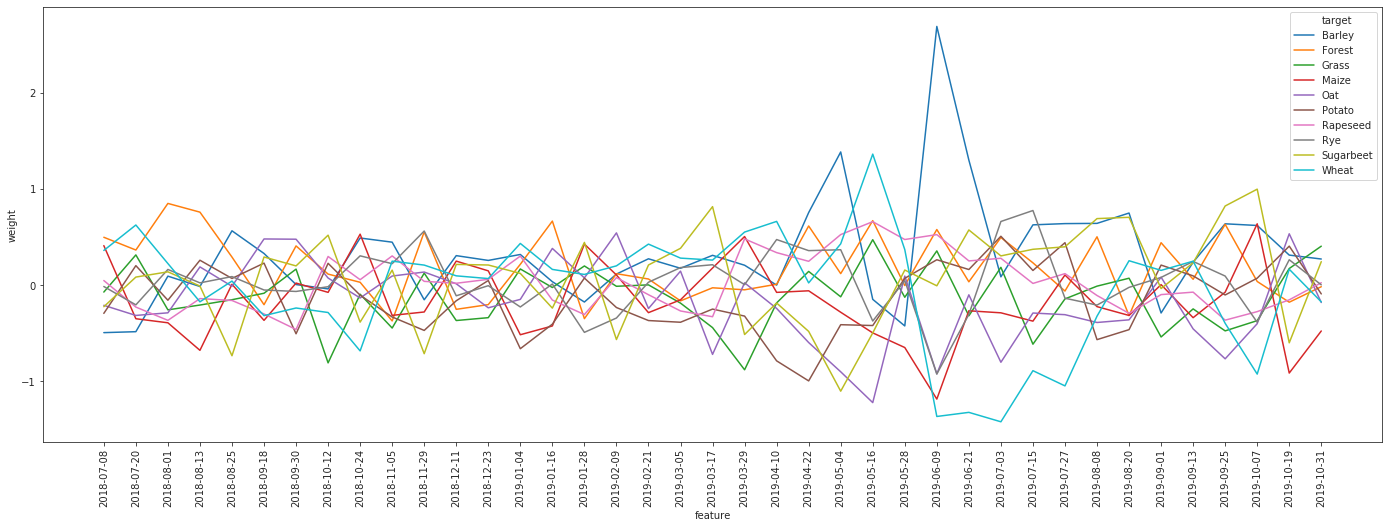

time: 616 ms


In [72]:
data = df_explanation[df_explanation['polarization'] == 'VH']
#data = data.loc[data['target'].isin(['Forest', 'Maize', 'Rapeseed'])]
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='target', data=data, ci='sd')

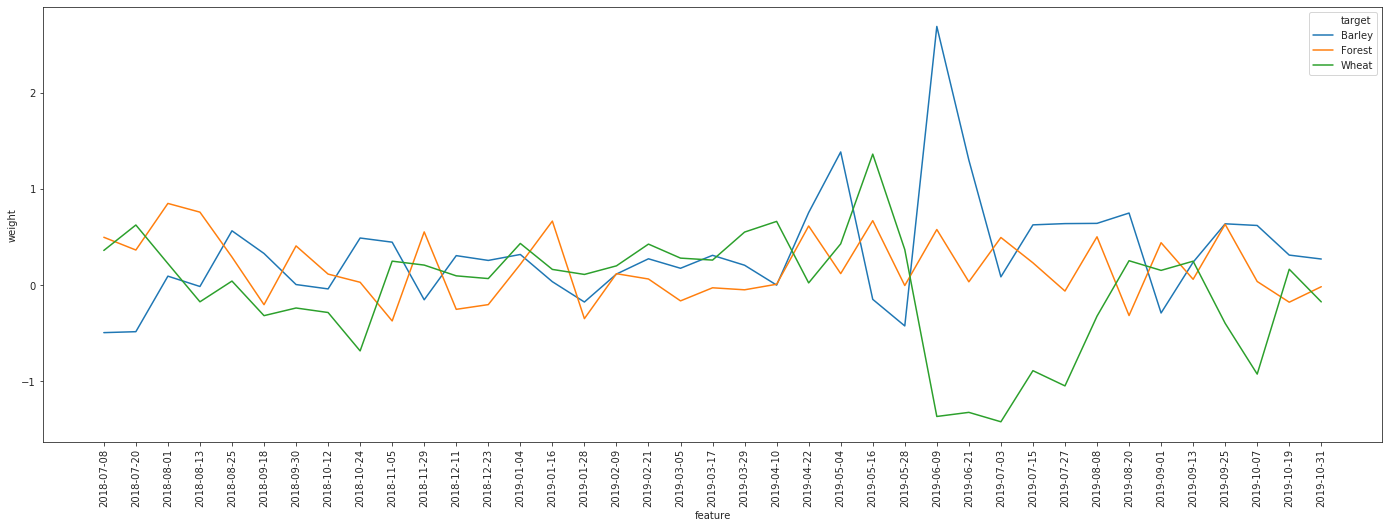

time: 410 ms


In [77]:
data = df_explanation[df_explanation['polarization'] == 'VH']
data = data.loc[data['target'].isin(['Barley', 'Wheat', 'Forest'])]
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='target', data=data, ci='sd')